In [1]:
import jax
import jax.numpy as jnp
import optax
from jax import jit


import matplotlib.pyplot as plt
import numpy as np


from tqdm import tqdm as tqdm
import pandas as pd


import time

In [2]:
def generate_gaussian_samples(mu, cov, n_samples, seed=0):


    d = mu.shape[0]
    key = jax.random.PRNGKey(seed)
    z = jax.random.normal(key, shape=(n_samples, d))


    L = jnp.linalg.cholesky(cov)
    samples = mu + z @ L.T
    
    
    return samples

In [3]:
def potential_grad(sample, mu, cov):


    precision = jnp.linalg.inv(cov)


    return (sample - mu) @ precision

In [4]:
def evolve_langevin(samples, mu, cov, eps=1e-2, n_evolution=100, seed=0):

    
    key = jax.random.PRNGKey(seed)
    evolved_samples = samples


    for i in range(n_evolution):
        key, subkey = jax.random.split(key)
        grad = potential_grad(evolved_samples, mu, cov)
        noise = jax.random.normal(subkey, shape=evolved_samples.shape)
        evolved_samples = evolved_samples - eps * grad + jnp.sqrt(2 * eps) * noise
        

    return evolved_samples

In [5]:
@jit


def pairwise_squared_distances(x, y):


    x_norm = jnp.sum(x**2, axis=1).reshape(-1, 1)
    y_norm = jnp.sum(y**2, axis=1).reshape(1, -1)


    return x_norm + y_norm - 2 * jnp.dot(x, y.T)


def sinkhorn(a, b, C, epsilon=0.1, n_iters=100):


    K = jnp.exp(-C / epsilon)
    u = jnp.ones_like(a)
    v = jnp.ones_like(b)


    for _ in range(n_iters):
        u = a / (K @ v + 1e-9)
        v = b / (K.T @ u + 1e-9)


    transport_plan = jnp.outer(u, v) * K
    return jnp.sum(transport_plan * C)


def compute_sinkhorn(samples, evolved_samples, epsilon=0.1, n_iters=10):


    n = samples.shape[0]
    m = evolved_samples.shape[0]

    
    a = jnp.ones(n) / n
    b = jnp.ones(m) / m


    C_xy = pairwise_squared_distances(samples, evolved_samples)
    C_xx = pairwise_squared_distances(samples, samples)
    C_yy = pairwise_squared_distances(evolved_samples, evolved_samples)


    sink_xy = sinkhorn(a, b, C_xy, epsilon, n_iters)
    sink_xx = sinkhorn(a, a, C_xx, epsilon, n_iters)
    sink_yy = sinkhorn(b, b, C_yy, epsilon, n_iters)


    return sink_xy - 0.5 * (sink_xx + sink_yy)

In [6]:
def lm_loss(samples, mu, cov):


    evolved_samples = evolve_langevin(samples, mu, cov)


    return compute_sinkhorn(samples, evolved_samples)

In [7]:
def lm_optimize_with_tracking(
    samples,
    true_mu,
    true_cov,
    n_epochs=1000,
    base_lr=1e-2,
    seed=10,
    eps=1e-2,
    plot_every=2,
    use_lr_schedule=True
):
    

    n, d = samples.shape


    key = jax.random.PRNGKey(seed)
    key_mu, key_A = jax.random.split(key)


    mu = jax.random.normal(key_mu, shape=(d,))
    A = jax.random.normal(key_A, shape=(d, d))


    params = {
        "mu": mu,
        "A": A
    }


    if use_lr_schedule:
        lr_schedule = optax.linear_schedule(
            init_value=1e-2,
            end_value=base_lr,
            transition_steps=500
        )
        optimizer = optax.adam(learning_rate=lr_schedule)
    else:
        optimizer = optax.adam(learning_rate=base_lr)


    opt_state = optimizer.init(params)


    def loss_fn(params, samples):
        mu = params["mu"]
        A = params["A"]
        cov = A.T @ A
        return lm_loss(samples, mu, cov)


    history = {
        "loss": [],
        "mu_l2": [],
        "cov_fro": [],
    }


    for epoch in range(n_epochs):
        loss_val, grads = jax.value_and_grad(loss_fn)(params, samples)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)


        mu_val = params["mu"]
        A_val = params["A"]
        cov_val = A_val.T @ A_val


        history["loss"].append(loss_val)
        history["mu_l2"].append(jnp.linalg.norm(true_mu - mu_val))
        history["cov_fro"].append(jnp.linalg.norm(true_cov - cov_val, ord='fro'))


        if epoch % plot_every == 0 or epoch == n_epochs - 1:
            print(f"epoch {epoch} | loss = {loss_val:.6f}")


    final_mu = params["mu"]
    final_cov = params["A"].T @ params["A"]


    return final_mu, final_cov, history

In [8]:
mu = jnp.array([0.0, 1.0, -1.0])


cov = jnp.array([
    [1.0, 0.5, 0.2],
    [0.5, 1.0, 0.3],
    [0.2, 0.3, 1.0]
])

In [9]:
samples = generate_gaussian_samples(mu, cov, n_samples=2000, seed=0)


time_start = time.time()


final_mu, final_cov, history = lm_optimize_with_tracking(samples, mu, cov, n_epochs=800, base_lr=0.1, seed = 0)


time_end = time.time()
time_elapsed = time_end - time_start
time_round = time_elapsed/800
print(time_round)

epoch 0 | loss = 0.337222
epoch 2 | loss = 0.313835
epoch 4 | loss = 0.291191
epoch 6 | loss = 0.271815
epoch 8 | loss = 0.256621
epoch 10 | loss = 0.244327
epoch 12 | loss = 0.235241
epoch 14 | loss = 0.228566
epoch 16 | loss = 0.223592
epoch 18 | loss = 0.220615
epoch 20 | loss = 0.218616
epoch 22 | loss = 0.216967
epoch 24 | loss = 0.215411
epoch 26 | loss = 0.213826
epoch 28 | loss = 0.212176
epoch 30 | loss = 0.210565
epoch 32 | loss = 0.208940
epoch 34 | loss = 0.207209
epoch 36 | loss = 0.205257
epoch 38 | loss = 0.202954
epoch 40 | loss = 0.200279
epoch 42 | loss = 0.197547
epoch 44 | loss = 0.194546
epoch 46 | loss = 0.191168
epoch 48 | loss = 0.188055
epoch 50 | loss = 0.184928
epoch 52 | loss = 0.183157
epoch 54 | loss = 0.182478
epoch 56 | loss = 0.181680
epoch 58 | loss = 0.180986
epoch 60 | loss = 0.180612
epoch 62 | loss = 0.180359
epoch 64 | loss = 0.179772
epoch 66 | loss = 0.178497
epoch 68 | loss = 0.177652
epoch 70 | loss = 0.177707
epoch 72 | loss = 0.177830
epoch 

In [10]:
jnp.set_printoptions(precision=4, suppress=True)


print(jnp.round(mu, 4), "\n\n", jnp.round(final_mu, 4), jnp.linalg.norm(mu - final_mu)/jnp.linalg.norm(mu), "\n\n\n")
print(jnp.round(cov, 4), "\n\n", jnp.round(final_cov, 4), jnp.linalg.norm(cov - final_cov)/jnp.linalg.norm(cov), "\n\n\n")

[ 0.  1. -1.] 

 [-0.0124  1.0421 -1.0242] 0.035401177 



[[1.  0.5 0.2]
 [0.5 1.  0.3]
 [0.2 0.3 1. ]] 

 [[0.9412 0.4604 0.1713]
 [0.4604 0.9198 0.272 ]
 [0.1713 0.272  1.0495]] 0.070515014 





In [11]:
history_np = {k: np.array(v) for k, v in history.items()}

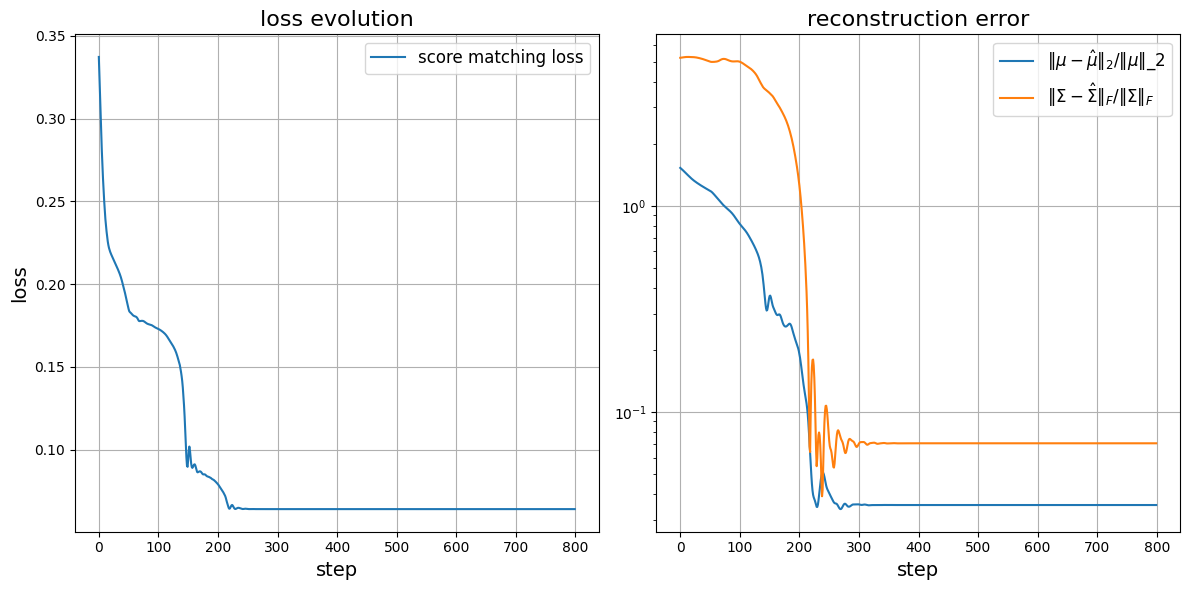

In [12]:
plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(history_np["loss"], label="score matching loss")
plt.xlabel("step", fontsize=14)
plt.ylabel("loss", fontsize=14)
plt.title("loss evolution", fontsize=16)
plt.grid(True)
plt.legend(fontsize=12)


plt.subplot(1, 2, 2)
plt.plot(history_np["mu_l2"]/np.linalg.norm(mu), label=r"$\| \mu - \hat{\mu} \|_2/\|\mu\|\_2$")
plt.plot(history_np["cov_fro"]/np.linalg.norm(cov), label=r"$\| \Sigma - \hat{\Sigma} \|_F/\|\Sigma\|_F$")
plt.yscale("log")
plt.xlabel("step", fontsize=14)
plt.title("reconstruction error", fontsize=16)
plt.grid(True)
plt.legend(fontsize=12)


plt.tight_layout()
plt.show()

In [13]:
sample_sizes = np.arange(50, 2001, 50)
n_steps = 800


all_losses = []
all_mu_errors = []
all_cov_errors = []


for n in tqdm(sample_sizes):
    samples = generate_gaussian_samples(mu, cov, n, seed=0)
    _, _, history = lm_optimize_with_tracking(samples, mu, cov, n_epochs=n_steps, base_lr=0.1, seed = 0)
    all_losses.append(np.array(history["loss"]))
    all_mu_errors.append(np.array(history["mu_l2"]))
    all_cov_errors.append(np.array(history["cov_fro"]))

  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0 | loss = 0.739105
epoch 2 | loss = 0.703164
epoch 4 | loss = 0.693035


  0%|          | 0/40 [00:02<?, ?it/s]

epoch 6 | loss = 0.693526


KeyboardInterrupt: 

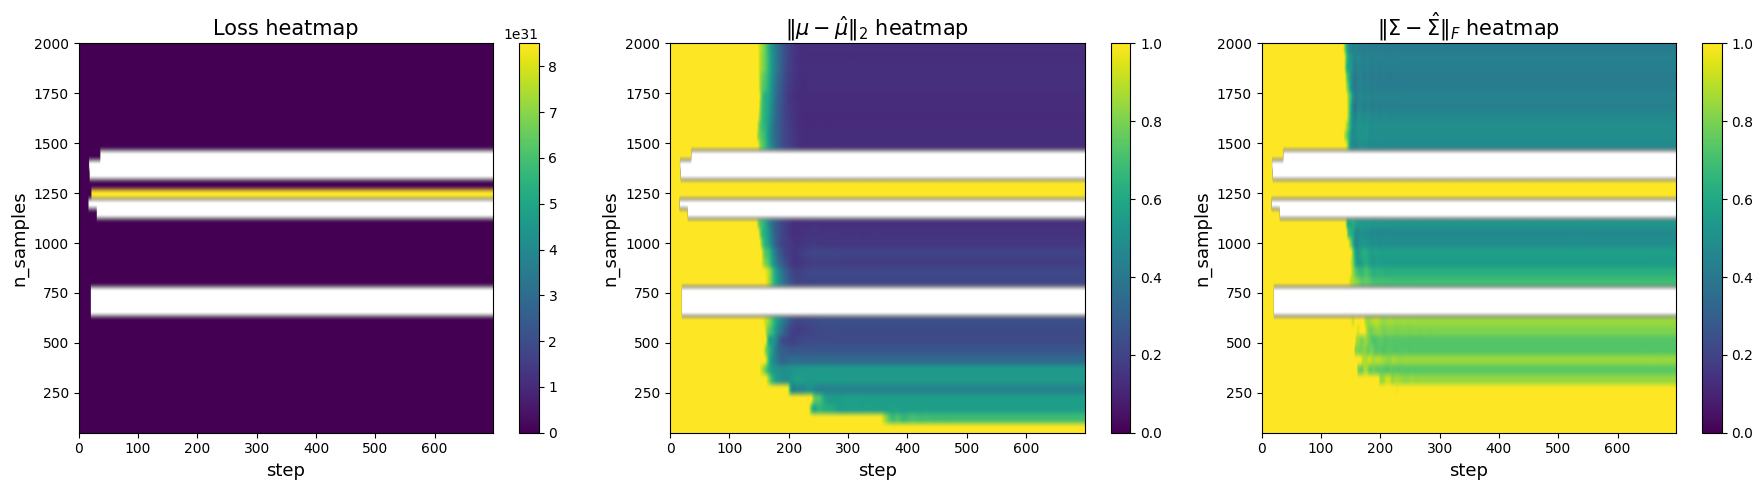

In [ ]:
loss_matrix = np.array(all_losses)
mu_err_matrix = np.array(all_mu_errors)/np.linalg.norm(mu)
cov_err_matrix = np.array(all_cov_errors)/np.linalg.norm(cov)


steps = np.linspace(0, n_steps, n_steps)
sample_sizes = np.arange(50, 2001, 50)


def plot_heatmap(data, title, ylabel, cmap="viridis", vmin=None, vmax=None):
    plt.imshow(data, aspect="auto", origin="lower", cmap=cmap,
               extent=[steps[0], steps[-1], sample_sizes[0], sample_sizes[-1]],
               vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.xlabel("step", fontsize=13)
    plt.ylabel("n_samples", fontsize=13)
    plt.title(title, fontsize=15)


plt.figure(figsize=(18, 5))


plt.subplot(1, 3, 1)
plot_heatmap(loss_matrix, "Loss heatmap", "n_samples")


plt.subplot(1, 3, 2)
plot_heatmap(mu_err_matrix, r"$\|\mu - \hat{\mu}\|_2/\|\mu\|_2$ heatmap", "n_samples", vmin=0.0, vmax=1.0)


plt.subplot(1, 3, 3)
plot_heatmap(cov_err_matrix, r"$\|\Sigma - \hat{\Sigma}\|_F/\|\Sigma\|_F$ heatmap", "n_samples", vmin=0.0, vmax=1.0)


plt.tight_layout()
plt.show()